In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [125]:
#Data extraction -
def extract_data(): 
  
  data=pd.read_csv("/content/drive/My Drive/Major_Project/dataset_with_values_v_3.csv", header=None)

  display(data.head())

  data = data.drop([data.columns[2] , data.columns[3], data.columns[4], data.columns[5]] ,  axis='columns')
  data.columns = ["Age", "Gender", "S1", "S2", "S3", "S4", "Doctor"]
  display(data.head())
  return data 

In [48]:
#Data distribution graph plotter -
def data_bar_graph(plotData):
  sns.set(style="ticks", color_codes=True)
  sns.countplot(x = 'Doctor', data = plotData, palette = 'hls')
  plt.show()

In [114]:
#Scale data and create and train LR & RF models. Store models in pickle file -
def create_models(x_set, x_test, y_set, y_test):
  #Scaling data -
  scaler = StandardScaler()
  scaler.fit(x_set)
  x_set = scaler.transform(x_set)
  x_test = scaler.transform(x_test) 

  #One Vs Rest Classifier -
  classifiers = []
  rf =[]
  for i in range(0,11):
    print("Training for class ", i+1, "\n")
    model = LogisticRegression()
    rf_model = RandomForestClassifier()
    model.fit(x_set, y_set[:,i])
    rf_model.fit(x_set, y_set[:,i])
    classifiers.append(model)
    rf.append(rf_model)

  with open("/content/drive/My Drive/Major_Project/lr_models_2.pckl", "wb") as f:
    for model in classifiers:
      pickle.dump(model, f)

  with open("/content/drive/My Drive/Major_Project/rf_models_2.pckl", "wb") as f:
    for model in rf:
      pickle.dump(model, f)    

  return classifiers, rf, x_test

In [124]:
#Calculating & displaying precision and accuracy values for 11 classes for LR & RF each -
def precision_accuracy(classifiers, rf, x_test, y_test): 
  row = []
  row_rf = []
  for i in range(0,11):
    pr = classifiers[i].predict(x_test) 
    cla = classification_report(y_test[:,i],  pr)  
    cla  = cla.split()
    precision = cla[25]
    accuracy = cla[27] 
    row.append([float(precision), float(accuracy)])
    pr_rf = rf[i].predict(x_test)
    cla = classification_report(y_test[:,i],  pr_rf)  
    cla  = cla.split()
    precision = cla[25]
    accuracy = cla[27] 
    row_rf.append([float(precision), float(accuracy)])

  cols_acc = ["Precision", "Accuracy"]
  acc_frame = pd.DataFrame(data = row, columns = cols_acc)

  cols_rf = ["Precision", "Accuracy"]
  acc_frame_rf = pd.DataFrame(data = row_rf, columns = cols_rf)

  print("Accuracy of LR:")
  display(acc_frame)
  print("Accuracy of RF: ")
  display(acc_frame_rf)

In [118]:
#Displaying probabilities for LR and RF models -
def predict_tests(classifiers, rf, x_test):  
  prediction = []
  prediction_rf = []
  for i in range(13,16):
    temp = []
    for model in classifiers:
      prob = model.predict_proba(x_test[i-1:i])  
      temp.append(prob[0][0])
    prediction.append(temp)  
    temp_rf = []
    for model_rf in rf:
      prob_rf = model_rf.predict_proba(x_test[i-1:i]) 
      temp_rf.append(prob_rf[0][0])
    prediction_rf.append(temp_rf)  

  cols = ["Allergist","Endocrinologist","General Physician","Cardiologist","Gastroenterologist","Nephrologist","Neurologist","Pediatrician","Psychiatrist","Pulmonologist","Rheumatologist"]

  final_prediction = pd.DataFrame(data=prediction, columns=cols)
  final_pred_rf = pd.DataFrame(data=prediction_rf, columns=cols)    

  print("LR")
  display(final_prediction)

  print("RF")
  display(final_pred_rf)

In [120]:
def test_pickle_models(x_test):
  models = []
  with open("/content/drive/My Drive/Major_Project/lr_models_2.pckl", "rb") as f:
      while True:
          try:
              models.append(pickle.load(f))
          except EOFError:
              break
  lr = []
  for i in range(15,25):
    temp = []
    for model in models:
      prob = model.predict_proba(x_test[i-1:i])  
      temp.append(prob[0][0])
    lr.append(temp)    

  cols = ["Allergist","Endocrinologist","General Physician","Cardiologist","Gastroenterologist","Nephrologist","Neurologist","Pediatrician","Psychiatrist","Pulmonologist","Rheumatologist"]

  lr_pred = pd.DataFrame(data=lr, columns=cols)   
  display(lr_pred)              

In [53]:
#Calculating relative probabilities -
def predict_label(X): 
  b=beta_val
  incpt=inter_val
  exp_val=[]
  for i in range(0,11): 
    numer=math.exp(incpt[i] + b[i][0]*X[0] + b[i][1]*X[1]+b[i][2]*X[2]+b[i][3]*X[3]+b[i][4]*X[4]+b[i][5]*X[5])
    exp_val.append(numer)
  prob = []
  for i in range(11):
    deno = 1 + (exp_val[1] + exp_val[2]+exp_val[3]+exp_val[4]+exp_val[5]+exp_val[6]+exp_val[7]+exp_val[8]+exp_val[9]+exp_val[10])
    numer = exp_val[i]
    prob.append(numer/deno)
  return prob

In [122]:
##______________MAIN_______________##
def main_function():
  
  dataSet = extract_data() 

  data_bar_graph(dataSet)

  #Splitting labels and data -
  test_train_data = dataSet.sample(frac=1)
  t = test_train_data
  X = t[t.columns[:6]]
  Y = t[t.columns[ 6]]

  display(X.head(), Y.shape)

  #Split Y into cols of labels -
  from sklearn.preprocessing import OneHotEncoder
  n = Y.values
  n = n.reshape(-1, 1)
  onehotencoder = OneHotEncoder( )

  y_split = onehotencoder.fit_transform(n).toarray()
 
  #Test & Train split -
  x_set = X.iloc[:5000,:]
  y_set = y_split[:5000,:] 

  x_test = X.iloc[5000:,:]
  y_test = y_split[5000:,:]

  print(x_set.shape, x_test.shape, y_set.shape, y_test.shape)

  #Pickle files are created in this function -
  classifiers, rf, x_test = create_models(x_set, x_test, y_set, y_test)
  
  # #Extract Beta values -
  # beta_val = []
  # inter_val = []
  # for i in range(0,11): 
  #   beta_val.append(classifiers[i].coef_[0]) 
  #   inter_val.append(classifiers[i].intercept_[0]) 
  
  precision_accuracy(classifiers, rf, x_test, y_test)
  predict_tests(classifiers, rf, x_test)
  test_pickle_models(x_test)
  

,0,1,2,3,4,5,6,7,8,9,10
0,1,1,659,1,Minor,upper respiratory infection,35,41,11,1,9
1,4,0,153,4,Major,asthma,7,19,9,41,0
2,3,0,126,2,Moderate,asthma,33,35,4,24,0
3,3,1,154,1,Minor,gastroenteritis,29,17,48,20,4
4,0,1,124,2,Minor,dehydration,19,10,50,25,10


,Age,Gender,S1,S2,S3,S4,Doctor
0,1,1,35,41,11,1,9
1,4,0,7,19,9,41,0
2,3,0,33,35,4,24,0
3,3,1,29,17,48,20,4
4,0,1,19,10,50,25,10


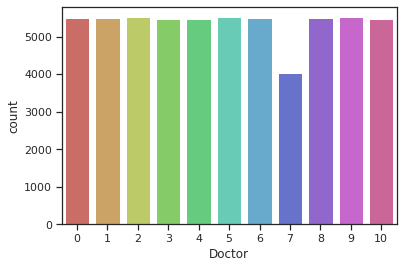

,Age,Gender,S1,S2,S3,S4
49968,0,0,33,35,4,24
24143,3,0,19,10,50,25
11015,3,0,33,35,4,24
23981,0,0,38,37,41,35
29615,3,0,0,15,45,52


(58999,)

(5000, 6) (53999, 6) (5000, 11) (53999, 11)
Training for class  1 

Training for class  2 

Training for class  3 

Training for class  4 

Training for class  5 

Training for class  6 

Training for class  7 

Training for class  8 

Training for class  9 

Training for class  10 

Training for class  11 



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classificat

Accuracy of LR:


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Precision,Accuracy
0,0.82,0.86
1,0.82,0.86
2,0.82,0.86
3,0.82,0.86
4,0.82,0.86
5,0.82,0.86
6,0.82,0.86
7,0.87,0.90
8,0.82,0.86
9,0.82,0.86


Accuracy of RF: 


,Precision,Accuracy
0,0.82,0.86
1,0.82,0.86
2,0.83,0.86
3,0.82,0.86
4,0.84,0.86
5,0.82,0.86
6,0.82,0.86
7,0.90,0.90
8,0.83,0.86
9,0.82,0.86


LR


,Allergist,Endocrinologist,General Physician,Cardiologist,Gastroenterologist,Nephrologist,Neurologist,Pediatrician,Psychiatrist,Pulmonologist,Rheumatologist
0,0.916914,0.925261,0.925394,0.903893,0.917941,0.905496,0.903371,0.989187,0.901943,0.913243,0.928023
1,0.876957,0.908280,0.914158,0.872028,0.900164,0.884848,0.870553,1.000000,0.884070,0.906476,0.894120
2,0.903273,0.895153,0.913902,0.883485,0.891030,0.907930,0.910663,0.999990,0.918384,0.901443,0.914694


RF


,Allergist,Endocrinologist,General Physician,Cardiologist,Gastroenterologist,Nephrologist,Neurologist,Pediatrician,Psychiatrist,Pulmonologist,Rheumatologist
0,0.942791,0.889795,0.924372,0.894501,0.840479,0.786482,0.931284,1.0,0.938233,0.898566,0.969236
1,0.948746,0.892539,0.937147,0.898377,0.870946,0.888632,0.888922,1.0,0.841304,0.969620,0.870507
2,0.970040,0.888635,0.885965,0.836413,0.886199,0.886270,0.859454,1.0,0.835553,0.969592,0.972703


,Allergist,Endocrinologist,General Physician,Cardiologist,Gastroenterologist,Nephrologist,Neurologist,Pediatrician,Psychiatrist,Pulmonologist,Rheumatologist
0,0.903273,0.895153,0.913902,0.883485,0.891030,0.907930,0.910663,0.999990,0.918384,0.901443,0.914694
1,0.922475,0.922684,0.903636,0.936009,0.905230,0.928580,0.930221,0.695670,0.924646,0.919962,0.918021
2,0.925367,0.922185,0.927056,0.915968,0.911726,0.913502,0.921360,0.716358,0.931267,0.913712,0.928783
3,0.890829,0.872708,0.890280,0.876914,0.880395,0.921116,0.901017,1.000000,0.920776,0.900530,0.900506
4,0.904701,0.914102,0.904296,0.903810,0.912401,0.917819,0.892721,0.999698,0.895959,0.913894,0.913132
5,0.899618,0.895806,0.886774,0.910516,0.883207,0.923899,0.920626,0.999989,0.910641,0.908492,0.902028
6,0.879688,0.889104,0.918840,0.848423,0.896092,0.890160,0.863964,1.000000,0.917980,0.900168,0.895814
7,0.915201,0.930029,0.928193,0.908835,0.916939,0.898705,0.907089,0.988290,0.898374,0.913959,0.924851
8,0.890211,0.887179,0.901901,0.873130,0.897773,0.914758,0.887662,1.000000,0.904668,0.900568,0.901520
9,0.914668,0.920957,0.924725,0.899367,0.909111,0.901163,0.915899,0.999569,0.890128,0.907001,0.928604


In [126]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
import pickle 
from sklearn.metrics import classification_report

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
 
main_function()